In [2]:
import re
import string
import pandas as pd
from datasets import Dataset
from transformers import AutoModelForSequenceClassification
from matplotlib import pyplot as plt
from transformers import AutoTokenizer


In [4]:
import seaborn as sns


In [7]:
df  = pd.read_csv('train.csv')

In [8]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Calculate the percentage of comments for each label
label_percentages = (df[label_cols].sum() / len(df)) * 100

print("Percentage of comments per label:")
print(label_percentages)

Percentage of comments per label:
toxic            9.584448
severe_toxic     0.999555
obscene          5.294822
threat           0.299553
insult           4.936361
identity_hate    0.880486
dtype: float64


/tmp/ipython-input-251519043.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_percentages.index, y=label_percentages.values, palette="viridis")


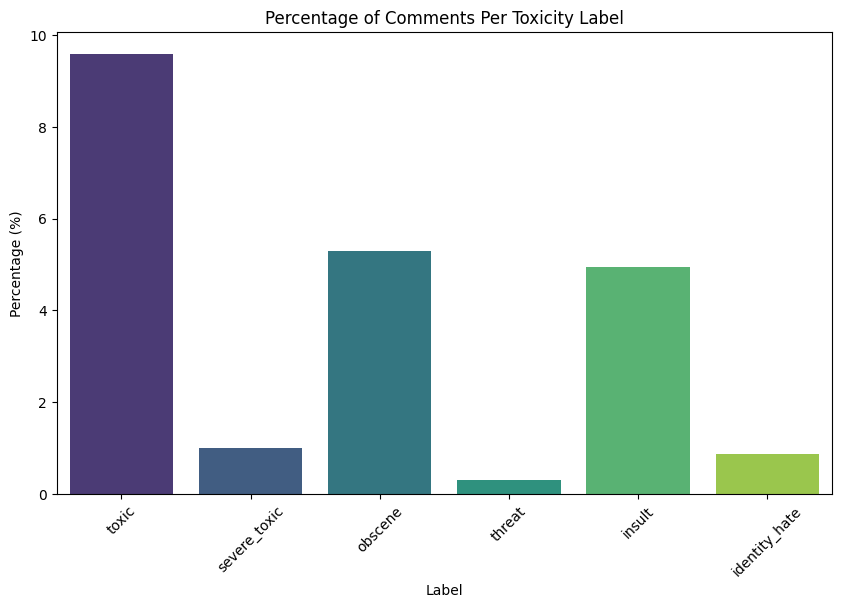

In [9]:
# Create a bar plot to visualize the percentages
plt.figure(figsize=(10, 6))
sns.barplot(x=label_percentages.index, y=label_percentages.values, palette="viridis")
plt.title('Percentage of Comments Per Toxicity Label')
plt.ylabel('Percentage (%)')
plt.xlabel('Label')
plt.xticks(rotation=45)
plt.show()

In [10]:
# Calculating the class weights
# We add a small number (1e-8) to avoid division by zero
pos_counts = df[label_cols].sum() + 1e-8

# Calculate the number of negative samples for each class
neg_counts = len(df) - pos_counts

# Calculate the positive class weights
# The formula is simply the ratio of negative to positive samples
pos_weights = neg_counts / pos_counts

print("Calculated Positive Class Weights:")
print(pos_weights)


# You will need these weights as a PyTorch tensor in your training script
# import torch
# pos_weights_tensor = torch.tensor(pos_weights.values, dtype=torch.float32)
# print("\nPyTorch Tensor:")
# print(pos_weights_tensor)

# Next Steps
# Now that you have these weights, the next step will be to modify your custom MultiLabelTrainer to use them.

Calculated Positive Class Weights:
toxic              9.433569
severe_toxic      99.044514
obscene           17.886377
threat           332.830544
insult            19.257839
identity_hate    112.573665
dtype: float64


In [3]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove line breaks and tabs
    text = text.replace('\n', ' ').replace('\t', ' ')

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [6]:
def load_and_process_data(df, tokenizer):
    # Process labels for multi-label classification
    label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    df['labels'] = df[label_cols].values.tolist()

    print("Cleaning text...")
    df['comment_text'] = df['comment_text'].apply(preprocess_text)

    df = df[['comment_text', 'labels']]

    # Convert to Hugging Face Dataset
    hg_dataset = Dataset.from_pandas(df)

    # Tokenize the dataset
    print("Tokenizing data...")
    tokenized_dataset = hg_dataset.map(
        tokenize_function,
        batched=True,
        fn_kwargs={'tokenizer': tokenizer, 'max_len': 128}
    )
    return tokenized_dataset

In [7]:
def tokenize_function(examples, tokenizer, max_len):
    """Tokenizes the text data."""
    output = tokenizer(
        examples['comment_text'],
        truncation=True,
        padding='max_length',
        max_length=max_len
    )
    return output

In [8]:
model_ckpt = "gpt2-medium"
output_path = "processed_data"

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer.pad_token = tokenizer.eos_token

# Load and process the data IN MEMORY
tokenized_dataset = load_and_process_data(df, tokenizer=tokenizer)
tokenized_dataset.save_to_disk(output_path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Cleaning text...
Tokenizing data...


Map:   0%|          | 0/159571 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/159571 [00:00<?, ? examples/s]